## Evaluation of Binary Classifiers
In machine learning, binary classification is the task of classifying elements of a given input into two groups, based on a classification rule. Here, we will define:

    - True Positives (TP): These are cases in which we predicted yes, and the actual output is also yes.
    - True Negatives (TN): We predicted no, and the actual output is no.
    - False Positives (FP): We predicted yes, but the actual output is no.
    - False Negatives (FN): We predicted no, but the actual output is yes.

The most common metrics for evaluating binary classification models are:
- **Accuracy** is the proportion of true results among the total number of cases examined. It's calculated as follows:

$$ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} $$

- **Precision**, also known as the positive predictive value, measures the proportion of positive predictions that are actually correct.

$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

- **Recall**, also known as sensitivity, hit rate, or true positive rate (TPR), measures the proportion of actual positives that are correctly identified.

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

- **The F1 Score** is the harmonic mean of precision and recall, aiming to balance these two values.

$$ \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$


### Evaluation function

In [1]:
import numpy as np

def calculate_metrics(test_data, parameters):
    predictions = test_data.map(lambda x: (x[0], 1 if np.dot(x[1], parameters) > 0 else 0))

    true_positive = predictions.map(lambda x: 1 if (x[0] == 1) and (x[1] == 1) else 0).reduce(lambda x, y: x + y)
    false_positive = predictions.map(lambda x: 1 if (x[0] == 0) and (x[1] == 1) else 0).reduce(lambda x, y: x + y)

    true_negative = predictions.map(lambda x: 1 if (x[0] == 0) and (x[1] == 0) else 0).reduce(lambda x, y: x + y)
    false_negative = predictions.map(lambda x: 1 if (x[0] == 1) and (x[1] == 0) else 0).reduce(lambda x, y: x + y)

    accuracy = (true_positive + true_negative) / test_data.count()
    f1 = true_positive / (true_positive + 0.5 * (false_positive + false_negative))

    contingency_matrix = {
        "TP": true_positive,
        "FP": false_positive,
        "FN": false_negative,
        "TN": true_negative
    }

    return contingency_matrix, accuracy, f1 

# Setup

### Setup environment

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Linear Regression Using GLM") \
    .getOrCreate()
sc = spark.sparkContext

### Generate data

In [3]:
from sklearn.datasets import make_blobs
from pandas import DataFrame
from matplotlib import pyplot
import matplotlib.cm as cm

n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 3 # max iterations 
n = 1000 # the number of total samples

ratio_positive = 0.5 # The classes ratio.
n_samples = [int(n*(1-ratio_positive)), int(n*ratio_positive)]
n_components = [1,1]
n_samples

# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples = n_samples, # the number of total samples
                  centers = None, # the number of clusters
                  n_features = n_feature, # the number of features
                  cluster_std = 1.5, # the std of each cluster
                  random_state = 2) # 2

#### Plot the data

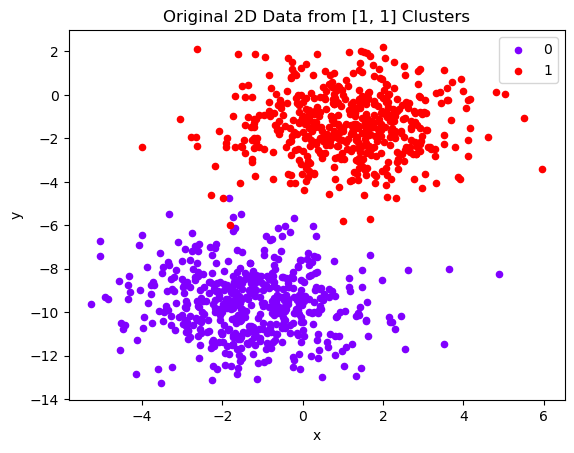

In [4]:
# Code for plotting the data
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

#### Prepare the data in RDD

In [5]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.8, 0.2], seed=12345)

### Train data

In [6]:
traindata = traindata.map(lambda x: (x[0],np.append(x[1],1)))
traindata.cache()
train_size = traindata.count()
traindata.take(3)

[(0, array([-1.24821068, -8.11509909,  1.        ])),
 (0, array([ -0.65894634, -11.01595769,   1.        ])),
 (1, array([ 0.40085031, -0.94999984,  1.        ]))]

### Test data

In [7]:
# Test data need to be in the same format as the train data
testdata = testdata.map(lambda x: (x[0], np.append(x[1], 1)))
test_size = testdata.count()
testdata.take(3)

[(1, array([ 1.36096253, -3.62447467,  1.        ])),
 (0, array([-1.70538123, -8.67383897,  1.        ])),
 (1, array([-0.31932964, -4.04208985,  1.        ]))]

# Evaluation of Gradient Descent Logistic Regression in PySpark 

### GD Logistic Regression
$$
\theta = X^T \beta = \sum_{j=1}^k \beta_i x_j
$$

So the negative log-likelihood for this GLM is:

$$
LLH = \sum_{i=1}^n - y_i \theta_i + \log(1+e^{\theta_i})
$$

This is the log-likelihood for a GLM with a Bernoulli distribution for $Y$, which is suitable for a binary classification problem.

The gradient of the log-likelihood function with respect to the parameter $\beta_j$ for the whole dataset of $n$ samples will be is given by:

$$
\frac{\partial LLH}{\partial \beta_j} =\sum_{i=1}^n - y_i x_{i,j} + x_{i,j} (\frac{ e^{\theta_i} }{1 + e^{\theta_i}})
$$

In [8]:
learningRate = 1
num_iteration = 10

# Calculate the dimensionality of the input data
d_input = len(traindata.first()[1])

# Initialize beta, ones are better than zeros for this case
beta = np.ones(d_input) 

print(f"Input dimension is {d_input} and start parameters are {beta}.")

# The main iterative part of gradient descent algorithm 
for i in range(num_iteration):

    gradientAndCost = traindata.map(lambda x: (x[1] * (-x[0] + np.exp(np.dot(x[1], beta))/(1+np.exp(np.dot(x[1], beta)))),
                                             -x[0] * np.dot(x[1],beta) + np.log(1 + np.exp(np.dot(x[1], beta)))))\
                             .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    cost = gradientAndCost[1] / float(train_size)
    gradient=(1 / float(train_size)) * gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")

Input dimension is 3 and start parameters are [1. 1. 1.].
0 Cost:0.36813 Beta [1.06562626 0.5977781  1.19037295]
1 Cost:0.21051 Beta [1.05537445 0.39593329 1.31262457]
2 Cost:0.17986 Beta [1.01771299 0.46724327 1.38519487]
3 Cost:0.17200 Beta [0.99051566 0.42644052 1.47153652]
4 Cost:0.16448 Beta [0.95993778 0.47388119 1.5418901 ]
5 Cost:0.15785 Beta [0.93609361 0.45309862 1.61984883]
6 Cost:0.15169 Beta [0.91130245 0.48481511 1.68741677]
7 Cost:0.14608 Beta [0.89086809 0.4768947  1.75861568]
8 Cost:0.14088 Beta [0.87071878 0.49818934 1.82315171]
9 Cost:0.13608 Beta [0.85341021 0.49824023 1.88880196]


### Evaluate the model

In [9]:
calculate_metrics(testdata, beta)

({'TP': 81, 'FP': 1, 'FN': 12, 'TN': 90},
 0.9293478260869565,
 0.9257142857142857)

# Evaluation of SVM implementation in PySpark

#### Loss Function

$$
\frac{\lambda}{2} || w ||^2 + \frac{1}{n} \sum\limits_i max(0, 1 - y_i (w.x_i))
$$

#### Gradient 
$$

\
\begin{align*}
\nabla J(w) = \begin{cases}
-w + C \sum_{i=1}^{m} y^{(i)}x^{(i)}, & \text{if } y^{(i)}w^Tx^{(i)} < 1 \\
-w, & \text{otherwise}
\end{cases}
\end{align*}
\
$$

In [10]:
learningRate = 0.2
num_iteration = 10
# Transform the data for the SVM
traindataSVM = traindata.map(lambda x: (1 if x[0] == 1 else -1, x[1]))
# Calculate the dimension of the input data
d_input = len(traindataSVM.first()[1])
weights = np.zeros(d_input)
print(f"Input dimension is {d_input} and start parameters are {weights}.")

# Let's start with the main iterative part of the gradient descent algorithm
for i in range(num_iteration):
    gradientAndCost = traindataSVM.map(lambda x: ((-x[0] * x[1]) if (x[0] * np.dot(x[1], weights)) < 1 else np.zeros(d_input),
                                                 max(0, 1 - x[0] * np.dot(x[1], weights))))\
                                  .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1] ))

    cost = gradientAndCost[1] / float(train_size)
    gradient = (1 / float(train_size)) * gradientAndCost[0]
    weights = weights - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} weights {weights}")

Input dimension is 3 and start parameters are [0. 0. 0.].
0 Cost:1.00000 weights [ 2.41779092e-01  8.30067280e-01 -4.90196078e-04]
1 Cost:0.94003 weights [0.34054947 0.68529054 0.09117647]
2 Cost:0.74804 weights [0.42734265 0.54248907 0.18063725]
3 Cost:0.57050 weights [0.50457106 0.40237229 0.26740196]
4 Cost:0.41056 weights [0.56201514 0.26995875 0.34632353]
5 Cost:0.29233 weights [0.5848799  0.16972735 0.41102941]
6 Cost:0.24788 weights [0.58101211 0.20154455 0.45392157]
7 Cost:0.23779 weights [0.58138493 0.1733833  0.50318627]
8 Cost:0.22852 weights [0.57174298 0.22202533 0.54068627]
9 Cost:0.21996 weights [0.57109535 0.18386305 0.58946078]


### Evaluate the model

In [11]:
calculate_metrics(testdata, weights)

({'TP': 77, 'FP': 2, 'FN': 16, 'TN': 89},
 0.9021739130434783,
 0.8953488372093024)

# Close Spark Session

In [12]:
spark.stop()